In [1]:
import xarray as xr
import pandas as pd
from glob import glob
from datetime import datetime as dt
import numpy as np
from associate_obs import identify_side

from matplotlib import pyplot as plt
from matplotlib import dates as pltdates
from matplotlib.gridspec import GridSpec
from metpy.plots import SkewT
from metpy import calc as mpcalc
from metpy.plots import USCOUNTIES
from metpy.units import units as un
from cartopy import crs as ccrs
from cartopy import feature as cfeat


px = 1/plt.rcParams['figure.dpi']


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
date_i_want = dt(2022, 6, 2)
tfm_path = f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze-obs.zarr'
tfm = xr.open_dataset(tfm_path, engine='zarr')

In [3]:
tfm

<xarray.Dataset> Size: 36GB
Dimensions:                           (feature: 16210, track: 770, time: 283,
                                       vertical_levels: 2000, y: 1001, x: 1001,
                                       cell: 945)
Coordinates:
  * track                             (track) float64 6kB 0.0 1.0 ... 769.0
  * time                              (time) datetime64[ns] 2kB 2022-06-02T00...
  * cell                              (cell) int64 8kB -1 4 6 ... 5092 5107 5110
  * feature                           (feature) int64 130kB 1 2 ... 16209 16210
  * vertical_levels                   (vertical_levels) int64 16kB 0 1 ... 1999
  * x                                 (x) float64 8kB -2.5e+05 ... 2.5e+05
  * y                                 (y) float64 8kB -2.5e+05 ... 2.5e+05
Data variables: (12/108)
    feature_rhvdeficitcol             (feature) float32 65kB ...
    track_pressure_profile            (track, time, vertical_levels) float64 3GB ...
    feature_lcl                       (feature) float64 130kB ...
    feature_time_index                (feature) int64 130kB ...
    track_seabreeze                   (track, time) float64 2MB ...
    feature_flash_count_area_GT_4km   (feature) float64 130kB ...
    ...                                ...
    track_temp_profile                (track, time, vertical_levels) float64 3GB ...
    feature_pressure_profile          (feature, vertical_levels) float64 259MB ...
    feature_parent_cell_id            (feature) int64 130kB ...
    feature_kdpwt_total               (feature) float64 130kB ...
    track_child_cell_count            (track) float64 6kB ...
    continental_dewpoint_profile      (time, vertical_levels) float64 5MB ...
Attributes:
    center_lat:      29.47190094
    center_lon:      -95.07873535
    soundings_used:  ['HOU_20220602_0030.csv', 'HOU_20220602_0150.csv', 'HOU_...

In [4]:
start_time = date_i_want.replace(hour=12)
end_time = date_i_want.replace(hour=23, minute=59, second=59)
if False:
    times_i_want = tfm.time.sel(time=slice(start_time, end_time)).data
    max_time_idx = times_i_want.shape[0]
    for i, time in enumerate(times_i_want):
        print(f'{i/max_time_idx*100:.2f}%')
        this_time = tfm.sel(time=time)
        for airmass in ['Continental', 'Maritime']:
            p = this_time[f'{airmass.lower()}_pressure_profile'].data * un.hPa
            T = this_time[f'{airmass.lower()}_temperature_profile'].data * un.degC
            Td = this_time[f'{airmass.lower()}_dewpoint_profile'].data * un.degC
            u = this_time[f'{airmass.lower()}_u_profile'].data * un.meter / un.second
            v = this_time[f'{airmass.lower()}_v_profile'].data * un.meter / un.second
            
            mask = mpcalc.resample_nn_1d(p.m,  np.logspace(4, 2))
            
            fig = plt.figure()
            skew = SkewT(fig)
            skew.plot(p, T, 'r')
            skew.plot(p, Td, 'lime')
            skew.ax.scatter([T[0]], [p[0]], color='r', s=10, edgecolors='k', zorder=5)
            skew.ax.scatter([Td[0]], [p[0]], color='lime', s=10, edgecolors='k', zorder=5)
            skew.plot_barbs(p[mask], u[mask], v[mask])

            skew.ax.set_title(f'{airmass} Representative Profile\n{time.astype('datetime64[m]').astype('O').strftime('%Y-%m-%d %H:%M')}')
            fig.set_size_inches(512*px, 512*px)
            fig.savefig(f'./agu_figs/wiggle_sounding/{airmass}/{str(i).zfill(4)}.png')
            plt.close(fig)

In [5]:
if False:
    arm_ccn_path = '/Volumes/LtgSSD/arm-ccn-avg/'
    arm_ccn_files = glob(arm_ccn_path+date_i_want.strftime('*%Y%m%d*.nc'))
    maritime_ccn = []
    maritime_times = []
    continental_ccn = []
    continental_times = []
    if len(arm_ccn_files) == 1:
        arm_ccn_file = arm_ccn_files[0]
        arm_ccn = xr.open_dataset(arm_ccn_file)
        arm_ccn_ccn = arm_ccn.N_CCN.data
        arm_ccn_time = arm_ccn.time.data
        readings_in_window = ((arm_ccn.supersaturation_calculated >= 0.6) & (arm_ccn.supersaturation_calculated <= 0.8))
        arm_ccn_ccn_window = arm_ccn_ccn[readings_in_window]
        arm_ccn_time_window = arm_ccn_time[readings_in_window]
        arm_ccn_lon = np.full(arm_ccn_time_window.shape, arm_ccn.lon.data)
        arm_ccn_lat = np.full(arm_ccn_time_window.shape, arm_ccn.lat.data)
        arm_ccn_sbf = identify_side(arm_ccn_time_window.astype('datetime64[s]').astype(float), arm_ccn_lon, arm_ccn_lat, tfm.time.compute().data.astype('datetime64[s]').astype(float),
                                            tfm.seabreeze.transpose('time', *tfm.lat.dims).compute().data, tfm.lon.compute().data, tfm.lat.compute().data)
        
        arm_ccn_maritime = arm_ccn_ccn_window[arm_ccn_sbf == -1]
        arm_maritime_time = arm_ccn_time_window[arm_ccn_sbf == -1]
        maritime_ccn.extend(arm_ccn_maritime.tolist())
        maritime_times.extend(arm_maritime_time.tolist())
        arm_ccn_continental = arm_ccn_ccn_window[arm_ccn_sbf == -2]
        arm_continental_time = arm_ccn_time_window[arm_ccn_sbf == -2]
        continental_ccn.extend(arm_ccn_continental.tolist())
        continental_times.extend(arm_continental_time.tolist())
    else:
        print(f'Warning, {len(arm_ccn_files)} ARM CCN files found!')
    tamu_ccn_path = '/Volumes/LtgSSD/brooks-ccn/'
    tamu_ccn_files = glob(tamu_ccn_path+date_i_want.strftime('*%y%m%d_ccn*.csv'))
    if len(tamu_ccn_files) == 1:
        tamu_ccn_file = tamu_ccn_files[0]
        tamu_ccn = pd.read_csv(tamu_ccn_file)
        tamu_ccn = tamu_ccn[tamu_ccn['SS'] == 0.6]
        tamu_times_window = pd.to_datetime(tamu_ccn.loc[:, 'Time'], format='%y%m%d %H:%M:%S').values
        tamu_ccn_window = tamu_ccn.loc[:, 'N_CCN'].values
        tamu_ccn_lon_window = tamu_ccn.loc[:, 'Longitude'].values
        tamu_ccn_lat_window = tamu_ccn.loc[:, 'Latitude'].values
        tamu_ccn_sbf = identify_side(tamu_times_window, tamu_ccn_lon_window, tamu_ccn_lat_window, tfm)
        tamu_ccn_maritime = tamu_ccn_window[tamu_ccn_sbf == -1]
        tamu_maritime_time = tamu_times_window[tamu_ccn_sbf == -1]
        maritime_ccn.extend(tamu_ccn_maritime.tolist())
        maritime_times.extend(tamu_maritime_time.tolist())
        tamu_ccn_continental = tamu_ccn_window[tamu_ccn_sbf == -2]
        tamu_continental_time = tamu_times_window[tamu_ccn_sbf == -2]
        continental_ccn.extend(tamu_ccn_continental.tolist())
        continental_times.extend(tamu_continental_time.tolist())
    else:
        print(f'Warning, {len(tamu_ccn_files)} TAMU CCN files found!')
    continental_sorting = np.argsort(continental_times)
    continental_times = np.array(continental_times)[continental_sorting]
    continental_ccn = np.array(continental_ccn)[continental_sorting]
    maritime_sorting = np.argsort(maritime_times)
    maritime_times = np.array(maritime_times)[maritime_sorting]
    maritime_ccn = np.array(maritime_ccn)[maritime_sorting]

    aerosol_example_fig = plt.figure()
    ax = aerosol_example_fig.gca()
    ax.scatter(arm_continental_time, arm_ccn_continental, label='Continental', s=15, color='r', edgecolors='k')
    ax.scatter(arm_maritime_time, arm_ccn_maritime, label='Maritime', s=15, color='b', edgecolors='k')
    ax.plot(tfm.time, tfm.continental_ccn_profile.isel(vertical_levels=0), color='r', linestyle=':')
    ax.plot(tfm.time, tfm.maritime_ccn_profile.isel(vertical_levels=0), color='b', linestyle=':')
    ax.set_xlim(start_time, end_time)
    ax.set_ylabel(r'CCN Concentration ($cm^{-3}$)')
    ax.set_xlabel('Time (UTC)')
    ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))
    ax.set_title(f'ARM La Porte CCN Counter\nRamping Mode Averaged, 0.6% supersaturation\n{date_i_want.strftime("%Y-%m-%d")}')
    ax.legend(loc='lower right')

Text(0.5, 1.0, 'tobac Seabreeze Tracks, 2022-06-02')

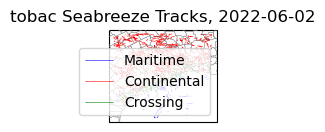

In [6]:
fig = plt.figure()
track_ax = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
# track_ax = plt.axes(projection=ccrs.PlateCarree())
mar_art = None
cont_art = None
cross_art = None
for this_track in tfm.track:
    this_track_ds = tfm.sel(track=this_track)
    # points_ax.scatter(this_track_ds.track_lon, this_track_ds.track_lat, c=this_track_ds.time, cmap='magma', s=3, zorder=3)
    this_track_sbf = np.nanmean(this_track_ds.track_seabreeze.data)
    if this_track_sbf == -1:
        mar_art, = track_ax.plot(this_track_ds.track_lon, this_track_ds.track_lat, c='b', linewidth=0.4, label='Maritime', zorder=2)
    elif this_track_sbf == -2:
        cont_art, = track_ax.plot(this_track_ds.track_lon, this_track_ds.track_lat, c='r', linewidth=0.4, label='Continental', zorder=2)
    else:
        cross_art, = track_ax.plot(this_track_ds.track_lon, this_track_ds.track_lat, c='g', linewidth=0.4, label='Crossing', zorder=2)
track_ax.add_feature(USCOUNTIES.with_scale('5m'), zorder=3, edgecolor='gray', linewidth=0.25)
# points_ax.add_feature(USCOUNTIES.with_scale('5m'), zorder=3, edgecolor='gray', linewidth=0.5)
track_ax.legend(handles=(mar_art, cont_art, cross_art), labels=('Maritime', 'Continental', 'Crossing'), loc='lower right')
track_ax.set_title(f'tobac Seabreeze Tracks, {date_i_want.strftime("%Y-%m-%d")}')
# track_fig.set_size_inches(720*px, 2*720*px)
# track_fig.tight_layout()


In [7]:
all_sbf_obs = sorted(glob('/Volumes/LtgSSD/tobac_saves/tobac_Save_*/seabreeze-obs.zarr'))
all_sbf_obs

['/Volumes/LtgSSD/tobac_saves/tobac_Save_20220602/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220604/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220617/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220622/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220702/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220706/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220712/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220713/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220714/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220728/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220729/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220801/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220802/seabreeze-obs.zarr',
 '/Volumes/LtgSSD/tobac_saves/tobac_Save_20220803/seabreeze-obs.zarr',
 '/Vol

In [8]:
track_ds = []
track_day = []
track_ccn = []
track_ecape = []
track_echotop = []
track_cloudtop = []

track_flash_count = []
track_kdp_vol = []
track_zdr_vol = []

track_seabreeze = []

for i, ds_path in enumerate(all_sbf_obs):
    this_ds = xr.open_dataset(ds_path, engine='zarr')
    track_ds.extend([i]*this_ds.track.shape[0])
    this_track_day = this_ds.time.data[0].astype('datetime64[D]').astype('O')
    track_day.extend([this_track_day]*this_ds.track.shape[0])
    track_ccn.extend(this_ds['track_ccn_profile_0.4'].isel(vertical_levels=0).mean(dim='time').data)
    track_ecape.extend(this_ds.track_mlecape.mean(dim='time').data)
    track_echotop.extend(this_ds.track_echo_top.max(dim='time').data/1000)
    track_cloudtop.extend(this_ds.track_min_L2_MCMIPC.min(dim='time').data - 273.15)

    track_flash_count.extend(this_ds.track_flash_count.sum(dim='time').data)
    track_kdp_vol.extend(this_ds.track_kdpvol.sum(dim='time').data)
    track_zdr_vol.extend(this_ds.track_zdrvol.sum(dim='time').data)
    track_seabreeze.extend(this_ds.track_seabreeze.mean(dim='time').data)

In [21]:
this_ds

<xarray.Dataset> Size: 37GB
Dimensions:                           (feature: 16067, track: 781, time: 293,
                                       y: 1001, x: 1001, vertical_levels: 2000,
                                       cell: 984)
Coordinates:
  * track                             (track) float64 6kB 0.0 1.0 ... 780.0
  * time                              (time) datetime64[ns] 2kB 2022-09-17T00...
  * cell                              (cell) int64 8kB -1 5 9 ... 4728 4735 4740
  * vertical_levels                   (vertical_levels) int64 16kB 0 1 ... 1999
  * feature                           (feature) int64 129kB 1 2 ... 16066 16067
  * x                                 (x) float64 8kB -2.5e+05 ... 2.5e+05
  * y                                 (y) float64 8kB -2.5e+05 ... 2.5e+05
Data variables: (12/108)
    feature_rhvdeficitcol             (feature) float32 64kB ...
    track_seabreeze                   (track, time) float64 2MB nan nan ... -1.0
    feature_time_index                (feature) int64 129kB ...
    feature_flash_count_area_GT_4km   (feature) float64 129kB ...
    feature_lcl                       (feature) float64 129kB ...
    track_min_L2_MCMIPC               (track, time) float64 2MB nan ... 283.8
    ...                                ...
    feature_kdpwt_total               (feature) float64 129kB ...
    feature_pressure_profile          (feature, vertical_levels) float64 257MB ...
    feature_kdpcol_mean               (feature) float32 64kB ...
    continental_dewpoint_profile      (time, vertical_levels) float64 5MB ...
    feature_parent_cell_id            (feature) int64 129kB ...
    track_child_cell_count            (track) float64 6kB ...
Attributes:
    center_lat:      29.47190094
    center_lon:      -95.07873535
    soundings_used:  ['HOU_20220917_0110.csv', 'HOU_20220917_0130.csv', 'HOU_...

In [9]:
track_ds = np.array(track_ds)
track_day = np.array(track_day)
track_ccn = np.array(track_ccn)
track_ecape = np.array(track_ecape)
track_echotop = np.array(track_echotop)
track_cloudtop = np.array(track_cloudtop)

track_flash_count = np.array(track_flash_count)
track_kdp_vol = np.array(track_kdp_vol)
track_zdr_vol = np.array(track_zdr_vol)

track_seabreeze = np.array(track_seabreeze)

tracks_df = pd.DataFrame({
    'dataset_id' : track_ds,
    'track_day' : track_day,
    'track_ccn' : track_ccn,
    'track_ecape' : track_ecape,
    'track_echotop' : track_echotop,
    'track_cloudtop' : track_cloudtop,
    'track_flash_count' : track_flash_count,
    'track_kdp_vol' : track_kdp_vol,
    'track_zdr_vol' : track_zdr_vol,
    'track_seabreeze' : track_seabreeze
})

In [10]:
tracks_df

,dataset_id,track_day,track_ccn,track_ecape,track_echotop,track_cloudtop,track_flash_count,track_kdp_vol,track_zdr_vol,track_seabreeze
0,0,2022-06-02,NaN,NaN,NaN,NaN,0.000000,0.000,0.000,NaN
1,0,2022-06-02,356.577433,1080.536209,11.0,-54.318535,0.000000,0.000,0.000,-2.0
2,0,2022-06-02,354.995968,1062.500663,9.5,-47.266336,1.543840,0.000,11.250,-2.0
3,0,2022-06-02,352.656098,1041.913992,14.5,-66.489550,79.368512,1504.125,5519.125,-2.0
4,0,2022-06-02,351.321624,1029.704400,13.0,-56.658956,2.380034,14.375,357.375,-2.0
...,...,...,...,...,...,...,...,...,...,...
24963,24,2022-09-17,3105.680236,874.005366,10.5,-28.620899,0.000000,87.125,1438.125,-2.0
24964,24,2022-09-17,3105.680236,873.988816,8.5,-11.885266,0.000000,0.000,287.000,-2.0
24965,24,2022-09-17,877.973288,847.071335,11.5,4.109104,0.000000,0.000,2335.125,-1.0
24966,24,2022-09-17,877.973288,851.817225,10.0,7.436870,0.000000,0.000,757.375,-1.0


In [11]:
labels = ['Nothing', r'$Z_{DR}$', r'$K_{DP}$', r'$Z_{DR}$ $K_{DP}$', r'$Z_{DR}$ Lightning', r'$K_{DP}$ Lightning', r'$Z_{DR}$ $K_{DP}$ Lightning', 'Lightning']
bar_axes_list = []
for i, side in enumerate(['Continental', 'Maritime', 'Crossing']):
    ax = fig.add_subplot(1, 4, i+2)
    bar_axes_list.append(ax)
    if i == 2:
        track_df_side = tracks_df[(tracks_df['track_seabreeze'] > -2) & (tracks_df['track_seabreeze'] < -1)]
    else:
        track_df_side = tracks_df[tracks_df['track_seabreeze'] == i-2]
    days = []
    ntrackss = []
    nothing_fracs = []
    zdr_fracs = []
    kdp_fracs = []
    zdr_kdp_fracs = []
    zdr_lightning_fracs = []
    kdp_lightning_fracs = []
    everything_fracs = []
    lightning_fracs = []

    for day in track_df_side['track_day'].unique():
        tds = track_df_side[track_df_side['track_day'] == day]
        n_tracks = tds.shape[0]
        ntrackss.append(n_tracks)
        has_lightning = tds['track_flash_count'] > 0
        has_kdp = tds['track_kdp_vol'] > 0
        has_zdr = tds['track_zdr_vol'] > 0
        nothing_tracks = tds[~has_lightning & ~has_kdp & ~has_zdr]
        kdp_tracks = tds[~has_lightning & has_kdp & ~has_zdr]
        zdr_tracks = tds[~has_lightning & ~has_kdp & has_zdr]
        zdr_kdp_tracks = tds[~has_lightning & has_kdp & has_zdr]
        zdr_lightning_tracks = tds[has_lightning & ~has_kdp & has_zdr]
        kdp_lightning_tracks = tds[has_lightning & has_kdp & ~has_zdr]
        everything_tracks = tds[has_lightning & has_kdp & has_zdr]
        lightning_tracks = tds[has_lightning & ~has_kdp & ~has_zdr]

        for scatter_ind, xlabel in zip(['track_ccn', 'track_ecape', 'track_echotop', 'track_cloudtop'],
                                       [r'N CCN ($cm^{-3}$)', 'Mixed-Layer Entraining CAPE (J/kg)', '18 dBZ Echo Top (km)', 'Cloud Top (°C)']):
            compfig, compax = plt.subplots()
            compax.scatter(nothing_tracks[scatter_ind], nothing_tracks['track_flash_count'], label=labels[0], marker='o')
            compax.scatter(zdr_tracks[scatter_ind], zdr_tracks['track_flash_count'], label=labels[1], marker='+')
            compax.scatter(kdp_tracks[scatter_ind], kdp_tracks['track_flash_count'], label=labels[2], marker='^')
            compax.scatter(zdr_kdp_tracks[scatter_ind], zdr_kdp_tracks['track_flash_count'], label=labels[3], marker='x')
            compax.scatter(zdr_lightning_tracks[scatter_ind], zdr_lightning_tracks['track_flash_count'], label=labels[4], marker='4')
            compax.scatter(kdp_lightning_tracks[scatter_ind], kdp_lightning_tracks['track_flash_count'], label=labels[5], marker='8')
            compax.scatter(everything_tracks[scatter_ind], everything_tracks['track_flash_count'], label=labels[6], marker='>')
            compax.scatter(lightning_tracks[scatter_ind], lightning_tracks['track_flash_count'], label=labels[7], marker='s')
            compax.set_title(f'{side} tracks for {day.strftime("%Y-%m-%d")}')
            compax.set_xlabel(xlabel)
            compax.set_ylabel('Track Accumulated Flash Count')
            compfig.set_size_inches(720*px, 720*px)
            compfig.tight_layout()
            compfig.savefig(f'./agu_figs/track_scatters/{day.strftime("%Y-%m-%d")}_{side}_{scatter_ind}.pdf')
            plt.close(compfig)

        totals = [nothing_tracks.shape[0], zdr_tracks.shape[0], kdp_tracks.shape[0], zdr_kdp_tracks.shape[0], zdr_lightning_tracks.shape[0],
                  kdp_lightning_tracks.shape[0], everything_tracks.shape[0], lightning_tracks.shape[0]]
        for j, thing_to_update in enumerate([nothing_fracs, zdr_fracs, kdp_fracs, zdr_kdp_fracs, zdr_lightning_fracs, kdp_lightning_fracs, everything_fracs, lightning_fracs]):
            thing_to_update.append(totals[j] / n_tracks)
        days.append(day)
    day_strs = [f'{day.strftime("%d %b")}\nN={tot}' for day, tot in zip(days, ntrackss)]
    WIDTH_VAL = 0.6
    nothing = ax.bar(day_strs, nothing_fracs, width=WIDTH_VAL, label=labels[0])
    bottomsum = np.array(nothing_fracs)
    zdr = ax.bar(day_strs, zdr_fracs, bottom=bottomsum, width=WIDTH_VAL, label=labels[1])
    bottomsum += np.array(zdr_fracs)
    kdp = ax.bar(day_strs, kdp_fracs, bottom=bottomsum, width=WIDTH_VAL, label=labels[2])
    bottomsum += np.array(kdp_fracs)
    zdr_kdp = ax.bar(day_strs, zdr_kdp_fracs, bottom=bottomsum, width=WIDTH_VAL, label=labels[3])
    bottomsum += np.array(zdr_kdp_fracs)
    zdr_lightning = ax.bar(day_strs, zdr_lightning_fracs, bottom=bottomsum, width=WIDTH_VAL, label=labels[4])
    bottomsum += np.array(zdr_lightning_fracs)
    kdp_lightning = ax.bar(day_strs, kdp_lightning_fracs, bottom=bottomsum, width=WIDTH_VAL, label=labels[5])
    bottomsum += np.array(kdp_lightning_fracs)
    everything = ax.bar(day_strs, everything_fracs, bottom=bottomsum, width=WIDTH_VAL, label=labels[6])
    bottomsum += np.array(everything_fracs)
    lightning = ax.bar(day_strs, lightning_fracs, bottom=bottomsum, width=WIDTH_VAL, label=labels[7])
    # ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f'Track Fractions for {side} Tracks')

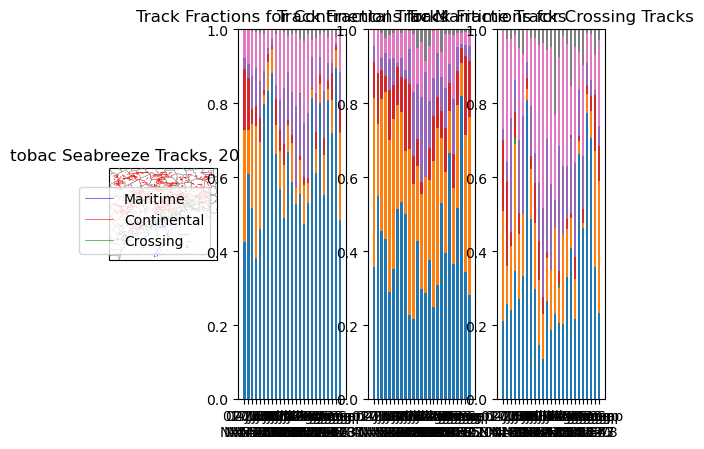

In [12]:
fig

In [13]:
track_ax.set_position([.05, .05, .3, .9])
bar_axes_list[0].set_position([.4-.025-.08, .2, .175+.015, .7])
bar_axes_list[1].set_position([.6-.025-.075, .2, .175+.015, .7])
bar_axes_list[2].set_position([.8-.025-.07, .2, .175+.015, .7])

In [14]:
legend_ax = fig.add_axes([.45-.08, .05, .45, .1])
legend_ax.axis('off')
legend_ax.legend(handles=(nothing, zdr, kdp, zdr_kdp, zdr_lightning, kdp_lightning, everything, lightning), labels=labels, loc='center', ncol=8)

In [15]:
fig.set_size_inches(13.5*3, 2*3)
fig.savefig('seminar_4_wide.png')

In [16]:
# fig.tight_layout()
# fig.savefig('./BAMS.pdf')

In [17]:
for day in tracks_df['track_day'].unique():
    tds = tracks_df[tracks_df['track_day'] == day]

    has_lightning = tds['track_flash_count'] > 0
    has_kdp = tds['track_kdp_vol'] > 0
    has_zdr = tds['track_zdr_vol'] > 0
    nothing_tracks = tds[~has_lightning & ~has_kdp & ~has_zdr]
    kdp_tracks = tds[~has_lightning & has_kdp & ~has_zdr]
    zdr_tracks = tds[~has_lightning & ~has_kdp & has_zdr]
    zdr_kdp_tracks = tds[~has_lightning & has_kdp & has_zdr]
    zdr_lightning_tracks = tds[has_lightning & ~has_kdp & has_zdr]
    kdp_lightning_tracks = tds[has_lightning & has_kdp & ~has_zdr]
    everything_tracks = tds[has_lightning & has_kdp & has_zdr]
    lightning_tracks = tds[has_lightning & ~has_kdp & ~has_zdr]

    for scatter_ind, xlabel in zip(['track_ccn', 'track_ecape', 'track_echotop', 'track_cloudtop'],
                                        [r'N CCN ($cm^{-3}$)', 'Mixed-Layer Entraining CAPE (J/kg)', '18 dBZ Echo Top (km)', 'Cloud Top (°C)']):
        compfig, compax = plt.subplots()
        compax.scatter(nothing_tracks[scatter_ind], nothing_tracks['track_flash_count'], label=labels[0], marker='o')
        compax.scatter(zdr_tracks[scatter_ind], zdr_tracks['track_flash_count'], label=labels[1], marker='+')
        compax.scatter(kdp_tracks[scatter_ind], kdp_tracks['track_flash_count'], label=labels[2], marker='^')
        compax.scatter(zdr_kdp_tracks[scatter_ind], zdr_kdp_tracks['track_flash_count'], label=labels[3], marker='x')
        compax.scatter(zdr_lightning_tracks[scatter_ind], zdr_lightning_tracks['track_flash_count'], label=labels[4], marker='4')
        compax.scatter(kdp_lightning_tracks[scatter_ind], kdp_lightning_tracks['track_flash_count'], label=labels[5], marker='8')
        compax.scatter(everything_tracks[scatter_ind], everything_tracks['track_flash_count'], label=labels[6], marker='>')
        compax.scatter(lightning_tracks[scatter_ind], lightning_tracks['track_flash_count'], label=labels[7], marker='s')
        compax.set_title(f'All tracks for {day.strftime("%Y-%m-%d")}')
        compax.set_xlabel(xlabel)
        compax.set_ylabel('Track Accumulated Flash Count')
        compfig.set_size_inches(720*px, 720*px)
        compfig.tight_layout()
        compfig.savefig(f'./agu_figs/track_scatters/{day.strftime("%Y-%m-%d")}_all_{scatter_ind}.pdf')
        plt.close(compfig)

In [20]:
tracks_df['track_day'].value_counts().sort_index()

track_day
2022-06-02     770
2022-06-04     516
2022-06-17     936
2022-06-22     650
2022-07-02    1058
2022-07-06     397
2022-07-12    1827
2022-07-13    1185
2022-07-14    1071
2022-07-28     914
2022-07-29     605
2022-08-01    1011
2022-08-02     347
2022-08-03     170
2022-08-06    1307
2022-08-07     797
2022-08-08     791
2022-08-13    1573
2022-08-21     941
2022-08-25    1626
2022-08-27    1528
2022-08-31    1419
2022-09-01    1382
2022-09-15    1366
2022-09-17     781
Name: count, dtype: int64

In [ ]:
for i, side in enumerate(['Continental', 'Maritime', 'Crossing', 'Total']):
    i -= 2
    if i == 0:
        track_ds_side = this_ds_minimal.where(((this_ds_minimal['track_seabreeze'] > -2) & (this_ds_minimal['track_seabreeze'] < -1)), drop=True)
    else:
        track_ds_side = this_ds_minimal.where(this_ds_minimal['track_seabreeze'] == i, drop=True)
    break

In [ ]:
max_ecape = 1500

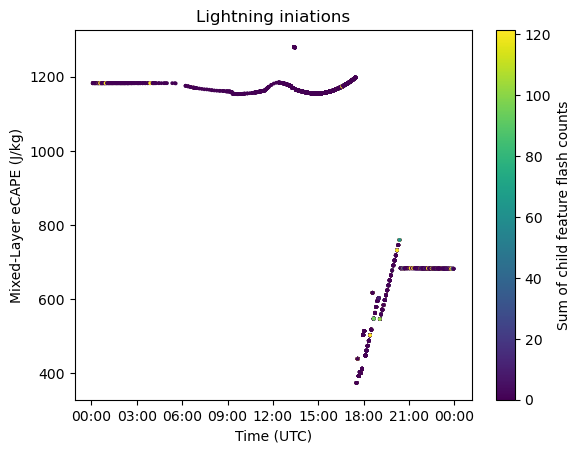

In [ ]:
fig, ax = plt.subplots()
for track in track_ds_side.track:
    this_track = track_ds_side.sel(track=track)
    sct = ax.scatter(this_track.time, this_track.track_mlecape, c=this_track.track_flash_count, s=3, label='Mixed-Layer eCAPE')
ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Mixed-Layer eCAPE (J/kg)')
ax.set_title('Lightning iniations')
fig.colorbar(sct, label='Sum of child feature flash counts')

# ax.scatter(track_ds_side.time.data, track_ds_side.track_flash_count)